#### Import all the required packages

In [18]:
## basic packages
import numpy as np
import re
import csv
import time
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

##gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

##spacy and nltk
import spacy
from nltk.corpus import stopwords
from spacy.lang.en.stop_words import STOP_WORDS

##vis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#### load the metadata of podcast transcripts

In [19]:
global df, show_descriptions

meta_data = []
with open("../data/metadata.tsv") as csvfile:
    csvreader = csv.reader(csvfile,delimiter="\t")
    for row in csvreader:
        meta_data.append(row)

df = pd.DataFrame(meta_data[1:],columns=meta_data[0])
show_filename_prefixes = df.show_filename_prefix
episode_filename_prefixes = df.episode_filename_prefix
shows = df.groupby(by=['show_name'])
show_names = shows.apply(lambda x: x.show_name.unique()[0])

In [20]:
nature_keywords = ["nature","photography","environment","ecosystem","wilderness","animals",\
                   "ocean","climate","landscape","waterfall","glacier","mountains","mountain",\
                   "coastal","geographic","birds","planter",\
                   "lakes","lake","volcano","earthquake","tsunami","flood","draught",\
                   "zoo","aquarium","desert","forest","forests","everglades",\
                   "cherry-blossom","spring","autumn","summer","winter","earth","planets",\
                   "marshland","frozen-lake","mammals","fish","reptiles","tornado","hurricane",\
                   "storm","thunder-storm","alaska","sahara","ghats","antarctica","arctic","pacific",\
                   "atlantic","garden","plants","himalayas","greenland","north-pole",\
                   "south-pole","greenhouse"]

genres_topics = nature_keywords

formats = ["monologue","interview","storytelling","repurposed",\
           "bite-sized","co-host conversation","debate","narrative",\
           "scripted","improvised"]

podcasts_genres_topics = {}
for k,show in enumerate(show_names):
    keywords = show.lower().split(" ")
    for word in keywords:
        if word in genres_topics:
            if (k,show) in podcasts_genres_topics:
                if word not in podcasts_genres_topics[(k,show)]:
                    podcasts_genres_topics[(k,show)].append(word)
            else:
                podcasts_genres_topics[(k,show)] = [word]
podcasts = [item[1] for item in podcasts_genres_topics.keys()]

In [21]:
nature_category = [(key,val) for key,val in podcasts_genres_topics.items() if ("nature" in val)\
                                                                    or ("photography" in val)\
                                                                    or ("environment" in val)\
                                                                    or ("ecosystem" in val)\
                                                                    or ("wilderness" in val)\
                                                                    or ("animals" in val)\
                                                                    or ("ocean" in val)\
                                                                    or ("climate" in val)\
                                                                    or ("landscape" in val)\
                                                                    or ("waterfall" in val)\
                                                                    or ("glacier" in val)\
                                                                    or ("mountains" in val)\
                                                                    or ("mountain" in val)\
                                                                    or ("coastal" in val)\
                                                                    or ("geographic" in val)\
                                                                    or ("birds" in val)\
                                                                    or ("planter" in val)\
                                                                    or ("lakes" in val)\
                                                                    or ("lake" in val)\
                                                                    or ("volcano" in val)\
                                                                    or ("earthquake" in val)\
                                                                    or ("tsunami" in val)\
                                                                    or ("flood" in val)\
                                                                    or ("draught" in val)\
                                                                  or ("zoo" in val)\
                                                                  or ("aquarium" in val)\
                                                                  or ("desert" in val)\
                                                                  or ("forest" in val)\
                                                                  or ("forests" in val)\
                                                                  or ("everglades" in val)\
                                                                  or ("cherry-blossom" in val)\
                                                                  or ("spring" in val)\
                                                                  or ("autumn" in val)\
                                                                  or ("summer" in val)\
                                                                  or ("winter" in val)\
                                                                  or ("earth" in val)\
                                                                  or ("planets" in val)\
                                                                  or ("marshland" in val)\
                                                                  or ("frozen-lake" in val)\
                                                                  or ("mammals" in val)\
                                                                  or ("fish" in val)\
                                                                  or ("reptiles" in val)\
                                                                  or ("tornado" in val)\
                                                                  or ("hurricane" in val)\
                                                                  or ("storm" in val)\
                                                                  or ("thunder-storm" in val)\
                                                                  or ("alaska" in val)\
                                                                  or ("sahara" in val)\
                                                                  or ("ghats" in val)\
                                                                  or ("himalayas" in val)\
                                                                  or ("antarctica" in val)\
                                                                  or ("arctic" in val)\
                                                                  or ("pacific" in val)\
                                                                  or ("atlantic" in val)\
                                                                  or ("garden" in val)\
                                                                  or ("plants" in val)\
                                                                  or ("greenhouse" in val)\
                                                                  or ("greenland" in val)\
                                                                  or ("north-pole" in val)\
                                                                  or ("south-pole" in val)]

In [22]:
nlp = spacy.load("en_core_web_sm")
stops_nltk = set(stopwords.words("english"))
stops_spacy = STOP_WORDS.union({'ll', 've', 'pron','okay','oh','like','know','yea','yep','yes','no',\
                                "like","oh","yeah","okay","wow","podcast","rating","ratings","not",\
                               "support","anchor","podcasts","episode","http","https","5star","reviews",\
                               "review","instagram","tiktok","amazon","apple","twitter","goole",\
                               "facebook","send","voice message","message","voice","subscribe","follow",\
                               "sponsor","links","easiest","way","fuck","fucking","talk","discuss",\
                               "world","time","want","join","learn","week","things","stuff","find",\
                               "enjoy","welcome","share","talk","talking","people","gmail","help","today",\
                               "listen","best","stories","story","hope","tips","great","journey",\
                               "topics","email","questions","question","going","life","good","friends",\
                               "friend","guys","discussing","live","work","student","students","need",\
                               "hear","think","change","free","better","little","fucking","fuck","shit",\
                                "bitch","sex","easiest","way","currently","follow","follows","needs",\
                               "grow","stay","tuned","walk","understand","tell","tells","ask","helps",\
                                "feel","feels","look","looks","meet","relate","soon","quick","dude","girl",\
                                "girls","guy","literally","spotify","google","totally","played","young",\
                               "begin","began","create","month","year","date","day","terms","lose","list",\
                               "bought","brings","bring","buy","percent","rate","increase","words","value",\
                               "search","awesome","followers","finn","jake","mark","america","american",\
                               "speak","funny","hours","hour","honestly","states","united","franklin",\
                               "patrick","john","build","dave","excited","process","processes","based",\
                                "focus","star","mary","chris","taylor","gotta","liked","hair","adam","chat",\
                               "named","died","born","country","mother","father","children","tools",\
                               "countries","jordan","tommy","listeners","water","jason","lauren","alex",\
                               "laguna","jessica","kristen","examples","example","heidi","stephen","utiful",\
                               "everybody","sorry","came","come","meet","whoa","whoaa","yay","whoaw",\
                               "anybody","somebody","cool","watch","nice","shall"})
stops = stops_nltk.union(stops_spacy)

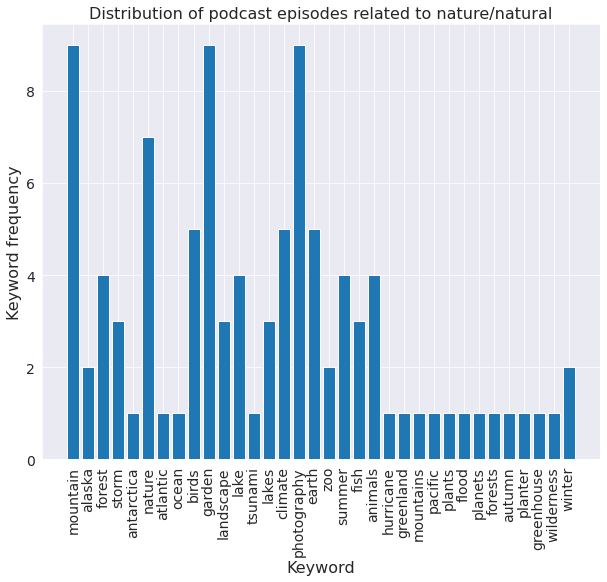

In [23]:
d = {}
for val in podcasts_genres_topics.values():
    for word in nature_keywords:
        if word in val:
            if word in d:
                d[word] += 1
            else:
                d[word] = 1
                
plt.figure(figsize=(10,8))
plt.bar(d.keys(),d.values())
plt.title('Distribution of podcast episodes related to nature/natural',fontsize=16)
plt.xlabel('Keyword',fontsize=16)
plt.ylabel('Keyword frequency',fontsize=16)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14);

In [ ]:
number_of_topics = [5,6,7,8,9,10,15]
df_parameters = list(product([2,3,4,5,6,7,8,9,10],[0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
hyperparams = list(product(number_of_topics,df_parameters))
nature_cs = []
with open('/home1/sgmark/capstone-project/results/coherence_scores_nature_category.csv','r') as f:
    reader = csv.reader(f)
    for row in reader:
        nature_cs.append([float(x) for x in row])
        
best_hp_setting = hyperparams[np.argmax([x[5] for x in nature_cs])]

#### The individual transcript location

In [ ]:
# def file_location(show,episode):
#     search_string = local_path + "/spotify-podcasts-2020" + "/podcasts-transcripts" \
#                                + "/" + show[0] \
#                                + "/" + show[1] \
#                                + "/" + "show_" + show \
#                                + "/"
#     return search_string

#### load the transcripts

In [24]:
transcripts = {}
for podcast,genre in nature_category:
    for i in shows.get_group(podcast[1])[['show_filename_prefix','episode_filename_prefix']].index:
        show,episode = shows.get_group(podcast[1])[['show_filename_prefix','episode_filename_prefix']].loc[i]
        s = show.split("_")[1]
        try:
            with open('/home1/sgmark/podcast_transcripts/'+s[0]+'/'+s[1]+'/'+show+'/'+episode+'.txt','r') as f:
                transcripts[(show,episode)] = f.readlines()
            f.close()
        except Exception as e:
            pass
    
keys = list(transcripts.keys())

In [ ]:
# Cleaning & remove urls and links
def remove_stops(text,stops):
    final = []
    for word in text:
        if (word not in stops) and (len(word)>3) and (not word.endswith('ing')) and (not word.endswith('ly')):
            final.append(word)
    return final
                       
def clean_text(docs):
    final = []
    for doc in docs:
        clean_doc = remove_stops(doc, stops)
        final.extend(clean_doc)
    return final

def lemmatization(text_data): 
    nlp = spacy.load("en_core_web_sm")
    texts = []
    for text in text_data:
        doc = nlp(text)
        lem_text = []
        for token in doc:
            if (token.pos_=="VERB") or (token.pos_=="ADV"):
                pass
            else:
                lem_text.append(token.lemma_)
        texts.append(lem_text)
    return texts

#### tokenize/convert text into words

In [ ]:
def normalize_docs(text_data):
    final_texts = []
    for text in text_data:
        new_text = gensim.utils.simple_preprocess(text,deacc=True)
        final_texts.append(new_text)
    return final_texts

In [ ]:
docs = []
for text in transcripts.values():
    docs.append(' '.join(clean_text(normalize_docs(text))))
    
texts = lemmatization(docs)
texts = [remove_stops(text,stops) for text in texts]

### Using bigrams

In [ ]:
from gensim.models.phrases import Phrases

bigram = Phrases(texts, min_count=5)

for i in range(len(texts)):
    for token in bigram[texts[i]]:
        if '_' in token:
            texts[i].append(token)

#### Construct a corpus of words as a bag of words 

In [ ]:
dictionary = corpora.Dictionary(texts)

dictionary.filter_extremes(no_below=best_hp_setting[1][0],no_above=best_hp_setting[1][1])

In [ ]:
corpus = [dictionary.doc2bow(text) for text in texts]

####  Hyperparameter tuning

In [ ]:
# from itertools import product

# number_of_topics = [5,6,7,8,9,10,15]
# df_parameters = list(product([2,3,4,5,6,7,8,9,10],[0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
# coherence_scores_umass = np.zeros((len(number_of_topics),len(df_parameters)))
# coherence_scores_uci = np.zeros((len(number_of_topics),len(df_parameters)))
# coherence_scores_npmi = np.zeros((len(number_of_topics),len(df_parameters)))

# j = 0
# for num in number_of_topics:
#     i = 0
#     for n,m in df_parameters:
#         dictionary = corpora.Dictionary(texts)
#         dictionary.filter_extremes(no_below=n,no_above=m)
#         corpus = [dictionary.doc2bow(text) for text in texts]
#         num_topics = num
#         chunksize = 200
#         passes = 20
#         iterations = 500
#         eval_every = None

#         lda_model = gensim.models.ldamodel.LdaModel(corpus,
#                                                    id2word=dictionary,
#                                                    num_topics=num_topics,
#                                                    chunksize=chunksize,
#                                                    passes=passes,
#                                                    iterations=iterations,
#                                                    alpha='auto',
#                                                    eta='auto',
#                                                    random_state = 123,
#                                                    eval_every=eval_every)
#         cm = CoherenceModel(lda_model, texts=texts,corpus=corpus, coherence= 'c_uci')
#         coherence_scores_uci[j,i] = cm.get_coherence()
#         cm = CoherenceModel(lda_model, texts=texts,corpus=corpus, coherence= 'c_npmi')
#         coherence_scores_npmi[j,i] = cm.get_coherence() 
#         cm = CoherenceModel(lda_model, corpus=corpus, coherence= 'u_mass')
#         coherence_scores_umass[j,i] = cm.get_coherence()
#         with open("coherence_scores_nature_category.csv",'a') as f:
#             writer = csv.writer(f)
#             writer.writerow([num,n,m,coherence_scores_uci[j,i],coherence_scores_npmi[j,i],\
#                              coherence_scores_umass[j,i]])
#         i += 1
#         print(i)
#     j += 1
#     print(j)

#### Final model

In [ ]:
%%time
import logging
logging.basicConfig(filename='nature_topics.log', encoding='utf-8',format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

num_topics = best_hp_setting[0]
chunksize = 200
passes = 50
iterations = 500
eval_every = None

lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           chunksize=chunksize,
                                           passes=passes,
                                           iterations=iterations,
                                           alpha='auto',
                                           eta='auto',
                                           random_state=123,
                                           eval_every=eval_every)

In [ ]:
top_topics = lda_model.top_topics(corpus,texts=texts,coherence='c_npmi') #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics])/num_topics

print('Average topic coherence: %.4f.' % avg_topic_coherence)
print(f'topic coherence scores: {[t[1] for t in top_topics]}')

### Visualizing data

In [ ]:
vis = pyLDAvis.gensim_models.prepare(lda_model,corpus,dictionary,mds="mmds",R=20)
pyLDAvis.save_json(vis,'nature_umass.json')
vis

In [ ]:
# from pprint import pprint
# pprint(top_topics)

In [ ]:
import pickle

pickle.dump(lda_model,open('../model/nature_episodes_lda_model_umass.pkl','wb'))
pickle.dump(dictionary,open('../model/nature_episodes_dictionary_umass.pkl','wb'))
pickle.dump(corpus,open('../model/nature_episodes_corpus_umass.pkl','wb'))
# pickle.dump(texts,open('../model/nature_episodes_texts.pkl','wb'))

In [26]:
import pickle

file = open('../model/nature_episodes_lda_model_umass.pkl','rb')
lda_model = pickle.load(file)
file.close()

file = open('../model/nature_episodes_corpus_umass.pkl','rb')
corpus = pickle.load(file)
file.close()

file = open('../model/nature_episodes_dictionary_umass.pkl','rb')
dictionary = pickle.load(file)
file.close()

file = open('../model/nature_episodes_texts.pkl','rb')
texts = pickle.load(file)
file.close()

In [27]:
def get_main_topic_df(model, bow, texts):
    topic_list = []
    percent_list = []
    keyword_list = []
    podcast_list = []
    episode_list = []
    duration_list = []
    publisher_list = []
    show_prefix_list = []
    episode_prefix_list = []
    descriptions_list = []
    rss_link_list = []
    
    for key,wc in zip(keys,bow):
        show_prefix_list.append(key[0])
        episode_prefix_list.append(key[1])
        podcast_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].show_name.iloc[0])
        episode_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].episode_name.iloc[0])
        duration_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].duration.iloc[0])
        publisher_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].publisher.iloc[0])
        descriptions_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].episode_description.iloc[0])
        rss_link_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].rss_link.iloc[0])
        
        topic, percent = sorted(model.get_document_topics(wc), key=lambda x: x[1], reverse=True)[0]
        topic_list.append(topic)
        percent_list.append(round(percent, 3))
        keyword_list.append(' '.join(sorted([x[0] for x in model.show_topic(topic)])))

    result_df = pd.concat([pd.Series(show_prefix_list, name='show_filename_prefix'),
                           pd.Series(episode_prefix_list, name='episode_filename_prefix'),
                           pd.Series(podcast_list, name='Podcast_name'),
                           pd.Series(episode_list, name='Episode_name'),
                           pd.Series(topic_list, name='Dominant_topic'), 
                           pd.Series(percent_list, name='Percent'), 
                           pd.Series(texts, name='Processed_text'), 
                           pd.Series(keyword_list, name='Keywords'),
                           pd.Series(duration_list, name='Duration of the episode'),
                           pd.Series(publisher_list, name='Publisher of the show'),
                           pd.Series(descriptions_list, name='Description of the episode'),
                           pd.Series(rss_link_list, name='rss_link')], axis=1)

    return result_df

In [28]:
main_topic_df = get_main_topic_df(lda_model,corpus,texts)
main_topic_df.to_pickle('../model/nature_topics_main_df_umass.pkl')
main_topic_df.to_csv('../model/main_df_csv/nature_topics_main_df_umass.csv')

In [ ]:
topics_terms = {k:lda_model.show_topic(k,topn=30) for k in range(lda_model.num_topics)}

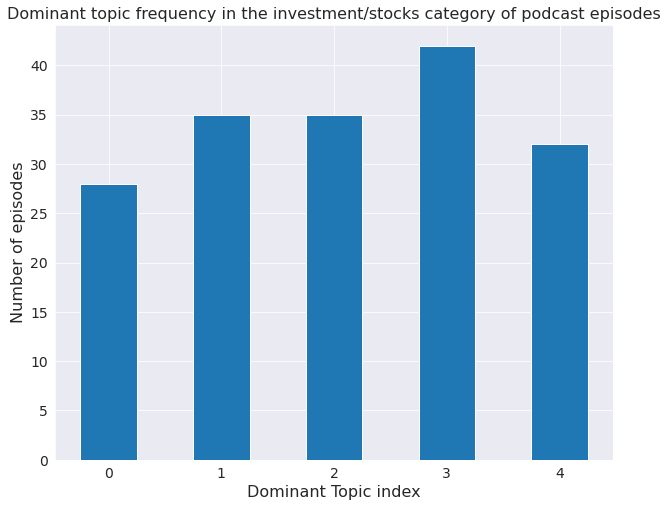

In [32]:
plt.figure(figsize=(10,8))
topics_groups = main_topic_df.groupby('Dominant_topic')
plt.bar(range(lda_model.num_topics),topics_groups.count()['Podcast_name'],width=0.5)
plt.title('Dominant topic frequency in the investment/stocks category of podcast episodes',fontsize=16)
plt.xlabel('Dominant Topic index',fontsize=16)
plt.ylabel('Number of episodes',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [33]:
representatives = pd.DataFrame()

for k in topics_groups.groups.keys():
    representatives = pd.concat([representatives, 
                                 topics_groups.get_group(k).sort_values(['Percent'], ascending=False).head(3)])

representatives.to_csv('../model/main_df_csv/nature_representatives_umass.csv')
# for k,words in enumerate(representatives.Keywords):
#     print(f'topic {k}: {words}')

In [ ]:
# print('Document: {}  Dominant topic: {}\n'.format(representatives.index[2], 
#                                        representatives.loc[representatives.index[2]]['Dominant_topic']))
# print([sentence.strip() for sentence in transcripts[keys[representatives.index[2]]]])

In [ ]:
num_topics = best_hp_setting[0]
def word_count_by_topic(topic=0):
    d_lens = [len(d) for d in topics_groups.get_group(topic)['Processed_text']]
    plt.figure(figsize=(10,8))
    plt.hist(d_lens)
    large = plt.gca().get_ylim()[1]
    d_mean = round(np.mean(d_lens), 1)
    d_median = np.median(d_lens)
    plt.plot([d_mean, d_mean], [0,large], label='Mean = {}'.format(d_mean))
    plt.plot([d_median, d_median], [0,large], label='Median = {}'.format(d_median))
    plt.legend()
    plt.xlabel('Document word count',fontsize=16)
    plt.ylabel('Number of documents',fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

In [ ]:
from ipywidgets import interact, IntSlider

slider = IntSlider(min=0, max=num_topics-1, step=1, value=0, description='Topic')
interact(word_count_by_topic, topic=slider);

In [ ]:
lda_top_words_index = set()
for i in range(lda_model.num_topics):
    lda_top_words_index = lda_top_words_index.union([k for (k,v) in lda_model.get_topic_terms(i)])
#print('Indices of top words: \n{}\n'.format(lda_top_words_index))

In [ ]:
words_we_care_about = [{dictionary[tup[0]]: tup[1] for tup in lst if tup[0] in list(lda_top_words_index)} 
                       for lst in corpus]

In [ ]:
lda_top_words_df = pd.DataFrame(words_we_care_about).fillna(0).astype(int).sort_index(axis=1)
lda_top_words_df['Cluster'] = main_topic_df['Dominant_topic']

In [ ]:
k=1
clusterwise_words_dist = lda_top_words_df.groupby('Cluster').get_group(k)
plt.figure(figsize=(30,8))
plt.bar(list(clusterwise_words_dist.sum()[:-1].transpose().index),\
        list(clusterwise_words_dist.sum()[:-1].transpose()))
plt.title(f'Term frequencies of keywords of topic: {k}',fontsize=16)
plt.xlabel('Keywords in the topics',fontsize=16)
plt.ylabel('Word frequency',fontsize=16)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14);

In [ ]:
word_totals = {k:{y[1]:y[0] for y in x[0]} for k,x in enumerate(top_topics)}

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from wordcloud import WordCloud

def show_wordcloud(topic=0):
    cloud = WordCloud(background_color='white', colormap='viridis')
    cloud.generate_from_frequencies(word_totals[topic])
    plt.figure(figsize=(10,8))
    plt.gca().imshow(cloud)
    plt.axis('off')
    plt.tight_layout()
    
slider = IntSlider(min=0, max=best_hp_setting[0]-1, step=1, value=0, description='Topic')
interact(show_wordcloud, topic=slider);

In [34]:
representatives

,show_filename_prefix,episode_filename_prefix,Podcast_name,Episode_name,Dominant_topic,Percent,Processed_text,Keywords,Duration of the episode,Publisher of the show,Description of the episode,rss_link
111,show_4GjcwZgf3MGvo1GKuouVkL,5ZcOsu40PiFE02f11QfivF,Raw Room Photography Podcast,The Ups and Downs of Photography Competitions,0,1.000,"[hello, photography, photo, photography, compe...",camera different image landscape mean photogra...,26.8228,Adam Karnacz,In this episode we discuss photography competi...,https://anchor.fm/s/72cdbf0/podcast/rss
89,show_3GQxWDGNrVe2L1wfGGaTmK,2L6FpEH7sgpkkm0gdb61xM,Photo Nerds Photography Podcast,What is Street Photography ? | Mirrorless vs M...,0,1.000,"[photo, nerd, lament, loss, team, member, stre...",camera different image landscape mean photogra...,48.4493,Photo Nerds,"After an extended break, we are back! In this ...",https://anchor.fm/s/8caec54/podcast/rss
93,show_3GQxWDGNrVe2L1wfGGaTmK,4VuJIIK4SJaOJOgDuNYAe6,Photo Nerds Photography Podcast,Getting Motivated to do Landscape Photography,0,1.000,"[forecast, gary, photography, motivate, camera...",camera different image landscape mean photogra...,52.5664,Photo Nerds,Getting motivated to get out and do landscape...,https://anchor.fm/s/8caec54/podcast/rss
154,show_4RY5robXqHB2zOaT1FTd5h,0IUU2GFZn8dbRF3d2F7e65,The Wilderness Medic Podcast,Episode 1: Dr Lucy Obolensky Joins Me to Discu...,1,1.000,"[wilderness, medic, daniel, lucy, obolensky, l...",able book different jesus kind mean nature pla...,29.1056,The Wilderness Medic,"Join me for a chat with Dr Lucy Obolensky, a m...",https://anchor.fm/s/f42fb1c/podcast/rss
20,show_25Itv5R9zPyOpi6uby8Uwm,1xUTdxLROP2aa18g1t6cZk,Fish and Scripts,"Svelte, Rollup and being proper adults",1,1.000,"[happy, fish, script, number, double, digit, p...",able book different jesus kind mean nature pla...,54.29286666666667,Jack and Phil,It's a new year but the same pod as we're back...,https://anchor.fm/s/cf40bd0/podcast/rss
148,show_4QEbgZ6wPzULQD7hRyHxm0,4eReyIRTd0TtsWADosRuxu,The Greenhouse Movement,Keeping the Main Thing the Main Thing,1,0.999,"[thank, greenhouse, movement, flight, empower,...",able book different jesus kind mean nature pla...,22.43435,Greenhouse Church,The first episode of our new podcast - Join ou...,https://anchor.fm/s/e837cd8/podcast/rss
53,show_0RDrChuBDfkdbjE4p46vXL,65sk1bOJXJq1Zx5xJaONl4,Let’s Buy Greenland FF Podcast,Let’s Buy Greenland FF podcast - Episode 1,2,1.000,"[greenland, fantasy, football, host, austin, b...",different game kind love mean point school son...,51.84086666666666,Austin Butts,This is our trial run of our unnamed podcast. ...,https://anchor.fm/s/ea514d8/podcast/rss
168,show_77DNwI2jNLuX77o5NqiH2r,4rDWrZpoj4LU0IRfQsx9yX,milked fish,T street and Keegan,2,1.000,"[milkfish, fudge, certain, record, edit, pocke...",different game kind love mean point school son...,45.56916666666667,milked fish,Today we have Keegan’s triumphant return to th...,https://anchor.fm/s/6b3f974/podcast/rss
120,show_0JCX6Uxm49LL4a6COGgnq6,3chb0wmHWESTjN6vF67LpM,SUMMER IN DECEMBER,Perspective and positive mindset,2,0.999,"[hello, summer, december, host, rudy, cruise, ...",different game kind love mean point school son...,20.19555,SUMMERinDECEMBER,"In this episode, we speak on a variety of thin...",https://anchor.fm/s/ffe4980/podcast/rss
73,show_2YmXPmgYeJP50QyuRt017s,567uVgKVh0Ysq59gVNHwWW,Murder At Land Between The Lakes,Roundtable Discussion,3,1.000,"[million, lanie, wrap, different, roundtable, ...",black body business case degree garden informa...,25.59845,Amelia Courtney,"Special edition: Roundtable episode, recapping...",https://anchor.fm/s/e6786a4/podcast/rss
